# Observing Earthquakes and Understanidng Seismic Waves

Our goal today is to see how we can use observations of ground shaking to understand earthquakes as well other signals in the Earth.  We'll spend most of the time using the seismograms below to determine the location, size, stress release, and duration of an impulsive earthquake.  Then we'll see if we can make sense of some more emergent seismic signals.

In [202]:
# to get started, we need to import some packages that are useful for analysing seismic data

# note that if you're running on your own computer, you may have to install obspy
# (try pip install obspy or go to anaconda navigator, then environments, and search for the package obspy)
# alternatively, you can do all the analysis on binder via a web browser, but
# note that you can't save any of your work there

# some built-in packages
import numpy as np
import obspy
import glob,os
import matplotlib.pyplot as plt
from matplotlib import gridspec

# some specific functions: take a look at some of these when you use them to
# see how they work
import earthquakefuns as eq
reload(eq)

<module 'earthquakefuns' from '/Users/eart0448/FILES/PYFILES/Courses/earthquakefuns.py'>

### 1. Read in seismic data

To start, let's read in some seismic data.  This uses obspy, which is a set of tools for seismic processing.  The data is a series of seismic traces, each of which records the speed of ground motion at the relevant station.

In [199]:
# read some seismograms
st=obspy.read(os.path.join('waveforms_corrected','*.mseed'))

# extract the first trace and describe it
tr=st[0]
print('The first trace is for station '+tr.stats.station+', in network '+tr.stats.network)
print(tr)
print('This trace is for one channel at this station: '+tr.stats.channel)
print('The last letter of the channel indicates the direction of motion.')
print('E or 1 means east, N or 2 means north, and Z means vertical.')

The first trace is for station BJT, in network IC
IC.BJT.00.BH1 | 2015-02-13T18:59:13.019534Z - 2015-02-13T20:09:12.969534Z | 20.0 Hz, 84000 samples
This trace is for one channel at this station: BH1
The last letter of the channel indicates the direction of motion.
E or 1 means east, N or 2 means north, and Z means vertical.


In [121]:
# note what else is in the seismic data
print(st)

258 Trace(s) in Stream:

IC.BJT.00.BH1 | 2015-02-13T18:59:13.019534Z - 2015-02-13T20:09:12.969534Z | 20.0 Hz, 84000 samples
...
(256 other traces)
...
IU.YSS.00.BHZ | 2015-02-13T18:59:13.049900Z - 2015-02-13T20:09:12.999900Z | 20.0 Hz, 84000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


### 2. Plot some seismic data

Next, let's plot the data.  The function eq.plotseismic will plot the seismic data.  Try playing around with some of the parameters:
1. stns: a list of the stations to plot, in that order
2. chn: which channel to plot, 'east', 'north', or 'vertical'
3. reftime: the reference time, which defines time=0
4. tlm: the time range to plot, in seconds since reftime
5. flm: a frequency band to filter the records to before plotting, in Hz

Identify some of the best stations and change the order of the stations to be plotted to something that you think is more sensible.

Also, really take a look at the seismic data.  Note what you see and what you think the records might mean.  Identify the various bursts of high-intensity ground motion.  Where do you think these bursts of shaking come from?  Which burst is which wave?

The avaialable stations are ADK, AFI, ANMO, ANTO, BILL, BJT, CASY, CCM, COLA, COR, CTAO, DAV, DWPF, ENH, FUNA, FURI, GNI, GRFO, GUMO, HIA, HKT, HNR, HRV, INCN, JOHN, KBL, KBS, KEV, KIP, KMI, KNTN, KONO, KOWA, LCO, LSA, LVC, MA2, MACI, MAJO, MAKZ, MBWA, MDJ, MIDW, NWAO, OTAV, PAB, PAYG, PET, PMG, PMSA, POHA, PTCN, PTGA, QIZ, QSPA, RAO, RAR, RCBR, RSSD, SAML, SBA, SDV, SFJD, SJG, SLBS, SNZO, SSE, SSPA, TARA, TATO, TEIG, TIXI, TRQA, TSUM, TUC, ULN, WAKE, WCI, WMQ, WVT, XAN, XMAS, YAK, YSS

The reference time is 
2015-02-13T18:59:00.000000Z


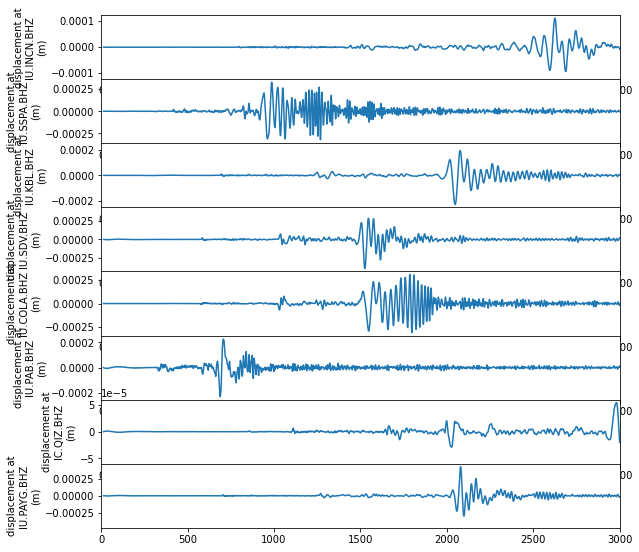

In [203]:
# note the available stations
stns=np.unique([tr.stats.station for tr in st])
print('The avaialable stations are '+', '.join(stns))

# the reference time
reftime=obspy.UTCDateTime(2015,2,13,18,59,0)
print('\nThe reference time is ')
print(reftime)

eq.plotseismic(st,chn='vertical',reftime=reftime,
               stns=['INCN','SSPA','KBL','SDV','COLA','PAB','QIZ','PAYG'],
               tlm=[0,3000])

###  3. Locating the earthquake: an intuitive understanding

Our next task is to locate the earthquake.  Below we can plot the locations of the seismic stations.  By visually examining the records and the station locations, can you guess where the earthquake was?

/Applications/anaconda3/envs/normal/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


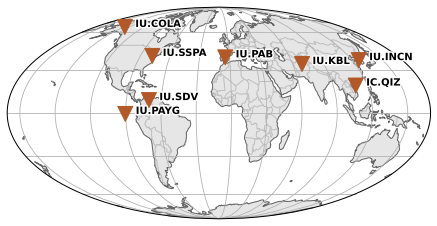

In [145]:
# read in some information about the station locations
#invi=obspy.read_inventory(os.path.join('stations','*.xml'))
dir(inv)

# so we can isolate just the stations of interest
invi=obspy.Inventory()
for stn in ['INCN','SSPA','KBL','SDV','COLA','PAB','QIZ','PAYG']:
    invi=invi+inv.select(station=stn)

# plot the station locations
invi.plot();


To be more precise, however, we can use what we know about seismic wave travel times in the Earth.  Specifically, we can model the propagtion of seismic waves through the Earth to predict the times required for P and S waves to travel certain distances.  

The figure below illustrates some of the ways a seismic wave can get from the earthquake (star) to the station (triangle).  Which ray paths are you most interested in if you want to locate the earthquake?

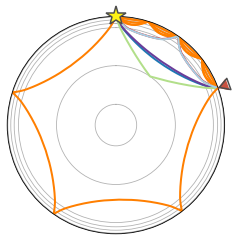

In [104]:
# we'll use a model that traces seismic rays through the Earth to predict their arrival times
from obspy import taup
taup.plot_ray_paths(source_depth=5,min_degrees=70,max_degrees=70,npoints=1,
                    phase_list=['P','S','PP','SS','ScS','PPPP','PKP']);



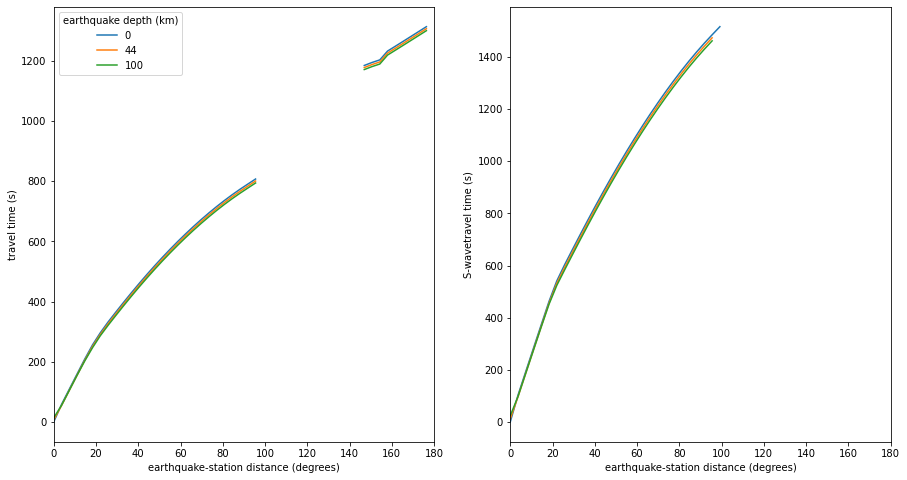

In [186]:
# let's compute the P and S wave travel times for particular earthquake depths and locations
distances,depths=np.linspace(0,180,50),np.linspace(0,100,10)
ptrav=np.ndarray([distances.size,depths.size],dtype=float)*float('nan')
strav=np.ndarray([distances.size,depths.size],dtype=float)*float('nan')

mdl=taup.TauPyModel(model='iasp91')
for kdist in range(0,distances.size):
    for kdepth in range(0,depths.size):
        # compute P-wave travel times
        parriv=mdl.get_travel_times(distance_in_degree=distances[kdist],
                                    source_depth_in_km=depths[kdepth],
                                    phase_list=['P','p','PKP'])
        if len(parriv):
            ptrav[kdist,kdepth]=np.min([ar.time for ar in parriv])
            
        # compute S-wave travel times
        sarriv=mdl.get_travel_times(distance_in_degree=distances[kdist],
                                    source_depth_in_km=depths[kdepth],
                                    phase_list=['S','s'])
        if len(sarriv):
            strav[kdist,kdepth]=np.min([ar.time for ar in sarriv])
            
# and let's plot some of these
f=plt.figure(figsize=(15,8))
gs,p=gridspec.GridSpec(1,2),[]
for gsi in gs:
    p.append(plt.subplot(gsi))

# for a few depths
idep=np.unique(np.linspace(0,depths.size-1,3).astype(int))
h=[]
for k in range(0,len(idep)):
    p[0].plot(distances,ptrav[:,idep[k]],label='{:0.0f}'.format(depths[idep[k]]))
    p[1].plot(distances,strav[:,idep[k]],label='{:0.0f}'.format(depths[idep[k]]))

lg=p[0].legend()
lg.set_title('earthquake depth (km)')
p[0].set_xlabel('earthquake-station distance (degrees)');
p[0].set_ylabel('travel time (s)');
p[1].set_xlabel('earthquake-station distance (degrees)');
p[1].set_ylabel('S-wavetravel time (s)');
p[0].set_xlim([0,180]);
p[1].set_xlim([0,180]);



But before we go on and use these predicted travel times, let's make sure we understand them.  Specifically, what's going at distances greater than about 90 degrees?  It may be useful to go back up and replot the raypaths for different earthquake-station distances.  In the cell 2 above, change both min_degrees and max_degrees to 80, 81, or even higher numbers to see what happens to the ray paths.

### 4. Locating the earthquake: a quantitative search

Now let's see if we can more quantitatively search for the earthquake time and location.  Edit the first two lines below, starting with 'parrivals' and 'sarrivals', to make a list of P and S wave arrival times that you'd like to match.

In [181]:
# observed P and S wave arrival times, in seconds relative to whatever reference time you defined above
parrivals={'SSPA':0.,'KBL':0.}
sarrivals={'SSPA':0.,'KBL':0.}

print('P wave time picks:')
print(parrivals)

print('\nS wave time picks:')
print(sarrivals)

# let's note the locations of all these stations
stats=np.unique(list(parrivals.keys())+list(sarrivals.keys()))
slocs={}
for stn in stats:
    invi=inv.select(station=stn)
    slocs[stn]=np.array([invi[0][0].longitude,invi[0][0].latitude])

print('\nA dictionary of the station locations:')
print(slocs)

P wave time picks:
{'SSPA': 0.0, 'KBL': 0.0}

S wave time picks:
{'SSPA': 0.0, 'KBL': 0.0}

A dictionary of the station locations:
{'KBL': array([ 69.0432,  34.5408]), 'SSPA': array([-77.8876,  40.6358])}


Let's propose that the earthquake occurred at time $t=10$ s relative to reftime at a depth of 10 km at a longitude of 170$^{\circ}$E and 30$^{\circ}$ N.  Would the predicted travel times match the data?

Try replacing the location and earthquake time with something more sensible below and see if you can get a better misfit.

In [184]:
# location
loc=[170,30,10]

# arrival times for this depth
idep=np.argmin(np.abs(depths-loc[0]))

# earthquake time
eqtim=10

# let's keep track of a misfit
msft = 0.

# contribution from misfit from P wave arrivals
print('P wave arrivals:\n')
print('Predicted, observed, misfit')
for stn in parrivals.keys():
    # station location
    sloc=slocs[stn]
    
    # distance from the proposed location to the station
    dst,az=eq.spheredist(np.array(loc[0:2]),sloc)
    dst=dst[0,0]
    
    # interpolate to predicted arrival times
    predtim=np.interp(dst,distances,ptrav[:,idep])+eqtim
    
    # add to misfit
    msfti=parrivals[stn]-predtim
    print('{:5s}{:6.1f},{:6.1f},{:6.1f}'.format(stn,predtim,parrivals[stn],msfti))
    
    msft=msft+np.abs(msfti)
    
# contribution from misfit from S wave arrivals
print('\n\nS wave arrivals:\n')
print('Predicted, observed, misfit')
for stn in parrivals.keys():
    # station location
    sloc=slocs[stn]
    
    # distance from the proposed location to the station
    dst,az=eq.spheredist(np.array(loc[0:2]),sloc)
    dst=dst[0,0]
    
    # interpolate to predicted arrival times
    predtim=np.interp(dst,distances,strav[:,idep])+eqtim
    
    # add to misfit
    msfti=sarrivals[stn]-predtim
    print('{:5s}{:6.1f},{:6.1f},{:6.1f}'.format(stn,predtim,sarrivals[stn],msfti))
    
    msft=msft+np.abs(msfti)
    
print('\nTotal misfift: {:0.1f}'.format(msft))

P wave arrivals:

Predicted, observed, misfit
SSPA  756.6,   0.0,-756.6
KBL   736.2,   0.0,-736.2


S wave arrivals:

Predicted, observed, misfit
SSPA 1380.2,   0.0,-1380.2
KBL  1339.9,   0.0,-1339.9

Total misfift: 4212.9


<br><br>

Is the location you expected a good match for the data?  Can you give a tectonic context for the earthquake we're looking at?

<br><br>
What do you think of the misfit as defined above?  Why might you use that misfit as opposed to another one?

<br><br>

If you have extra time, you might try a grid search for the best-fitting earthquake time and location.

<br><br>

### 5. Earthquake size

The next thing we might want to know about this earthquake is how big it is.  We generally define the size of an earthquake by computing the energy it releases, the earthquake moment $M_0$.  
$$M_0 = \textrm{slip} \times \textrm{area} \times \textrm{shear modulus}$$

The moment is the product of the slip on the fault times the area of the fault times a shear modulus, which is a measure of the elastic strength of the deforming crust.  For typical rocks, the shear modulus is around 40 GPa.

To simplify discussions of seismic moments, we often refer to earthquake _magnitudes_, where the moment magnitude is 

$$M_w = \frac{2}{3}\left(\log_{10}(M_0)-9.1\right)$$.

<br>

We determine earthquake magnitudes by measuring the amplitude of shaking at a range of stations.  However, the amount of shaking we observe at a given station depends not just the earthquake magnitude, but also on the distance of the station from the earthquake and on the structure of the ground beneath the station.   So we need to correct at least for the earthquake-station distance.

One rough estimate of an earthquake magnitude is the body wave magnitude $m_b$.  This magnitude is estimated by looking at the amplitude of the P- or S-wave arrivals and correcting for the earthquake-station distance with an empirical model.

$$m_b = \log_{10}\left(\frac{A}{T}\right) + Q(\textrm{earthquake distance},\textrm{earthquake depth})$$

Here $A$ is the amplitude of the P wave arrival in microns, $T$ is the dominant period of the signal we are examining, in seconds, and $Q$ is the empirical correction.

Let's plot the P wave arrival at one station, focussing on variation with 1-second periods, and estimate its amplitude.



Station distance: 69 degrees


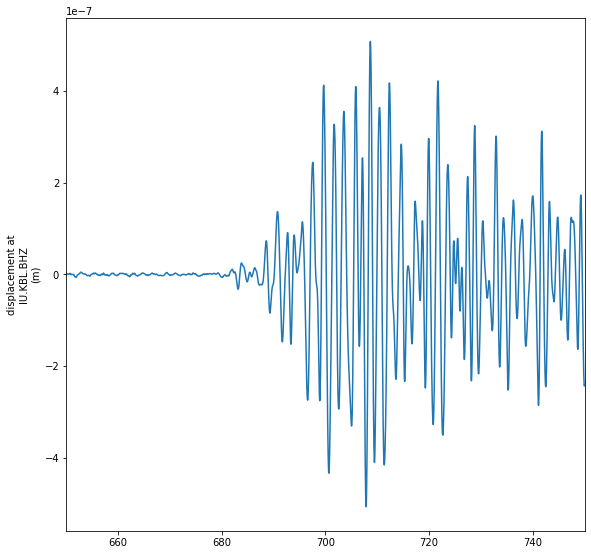

In [204]:
# plot the seismogram 
eq.plotseismic(st,chn='vertical',reftime=reftime,
               stns=['KBL'],tlm=[650,750],flm=[0.5,8])

# earthquake location
loc = np.array([-32.0,52.5,17])

# and compute the earthquake-station distance
dst,az=eq.spheredist(np.array(loc[0:2]),sloc)
dst=dst[0,0]
print('Station distance: {:0.0f} degrees'.format(dst))

The plot below gives one recent estimate of the P-wave body wave correction, made by Saloor and Okal (2020).  Use these corrections along with the amplitude and distances of three or four stations to determine the earthquake's magnitude and moment.

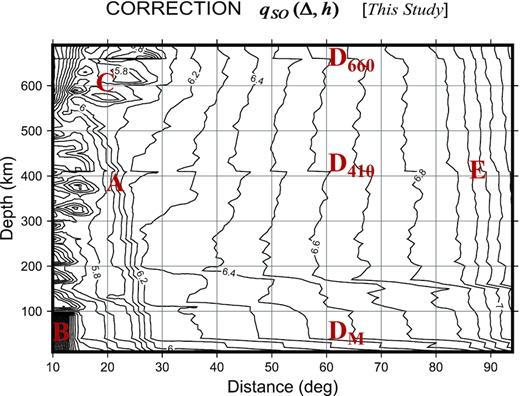

In [206]:
# read Q off the plot above
q=6.5

# compute body wave magnitude
#mb=

# take this body wave magnitude as an estimate of the moment magnitude and compute the moment
#Mo=

<br><br>
### 6. Earthquake duration

Now that we know where the earthquake is and how big it is in terms of moment, we can probe a little deeper.  To get a first order estimate of the earthquake duration, we can just measure the width of the first arriving pulse.  The seismic wave continues to push in one direction as the fault slips and then relaxes back after the earthquake stops.

Try plotting the P-wave signals from various stations.  How long did this earthquake last?

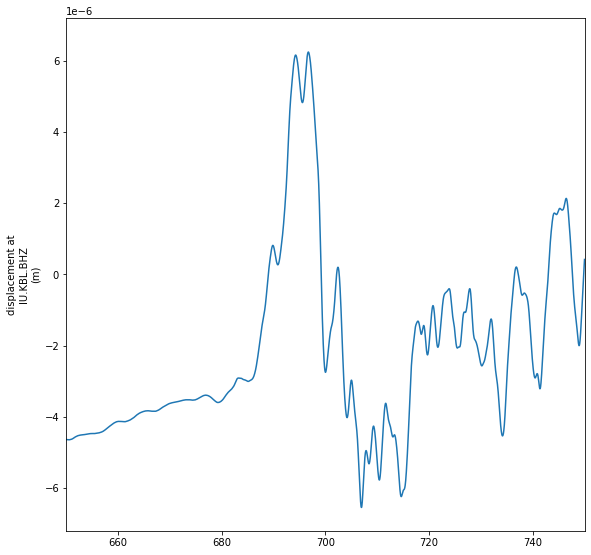

In [210]:
# plot the seismogram 
eq.plotseismic(st,chn='vertical',reftime=reftime,
               stns=['KBL'],tlm=[650,750],flm=[0.003,8])


### 7. Earthquake rupture dimensions

Earthquakes spread at a rate that is a significant fraction of the shear wave speed.  Let's assume that the shear wave speeed in the Earth is around 3 km/s, and that the earthquake spreads at 2/3rds that rate, or 2 km/s.  Given the duration estimated above, what is the earthquake's spatial extent?

What is the average slip in the slip in the earthquake?  The slip rate in an earthquake?  

What do you think controls the slip rate in an earthquake?

### 8. Other seismic signals

The above analysis works well for abrupt seismic signals like earthquakes.  However, many seismic signals are not created by earthquakes.  Let's look at a few different types of signals.  

<br><br>

Colouring in the figure below indicates the amplitudes of seismic waves recorded at stations in Poland at a range of frequencies, as documented by Lepore et al (2016). 

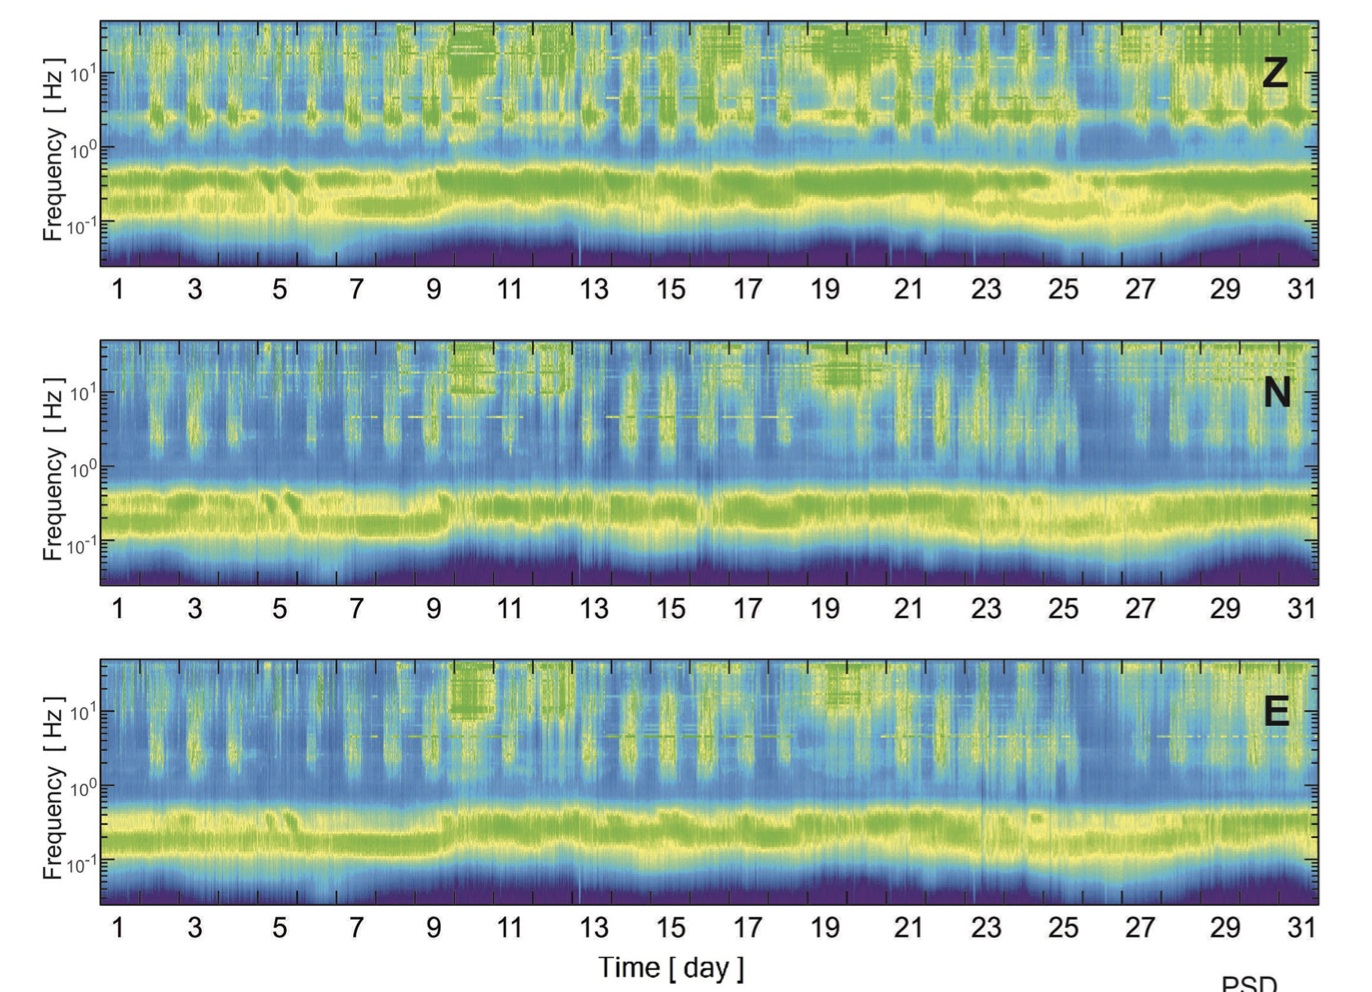

What do you think causes the periodic signal at frequencies higher than 1 Hz?

<br><br>

The continuous signals at frequencies below 1 Hz are well observed at stations around the world.  What do you think could cause that signal?

<br><br>

Here are some sporadic seismic signals recorded in central California, as reported by R. Hollister on Twitter.  Signals like these are pretty commonly recorded.  What do you think they are?

All the data here comes from one station, and each line corresponds to half an hour of recording.  The blown-up portion of the seismogram is a normal earthquake that occurred in New Zealand.

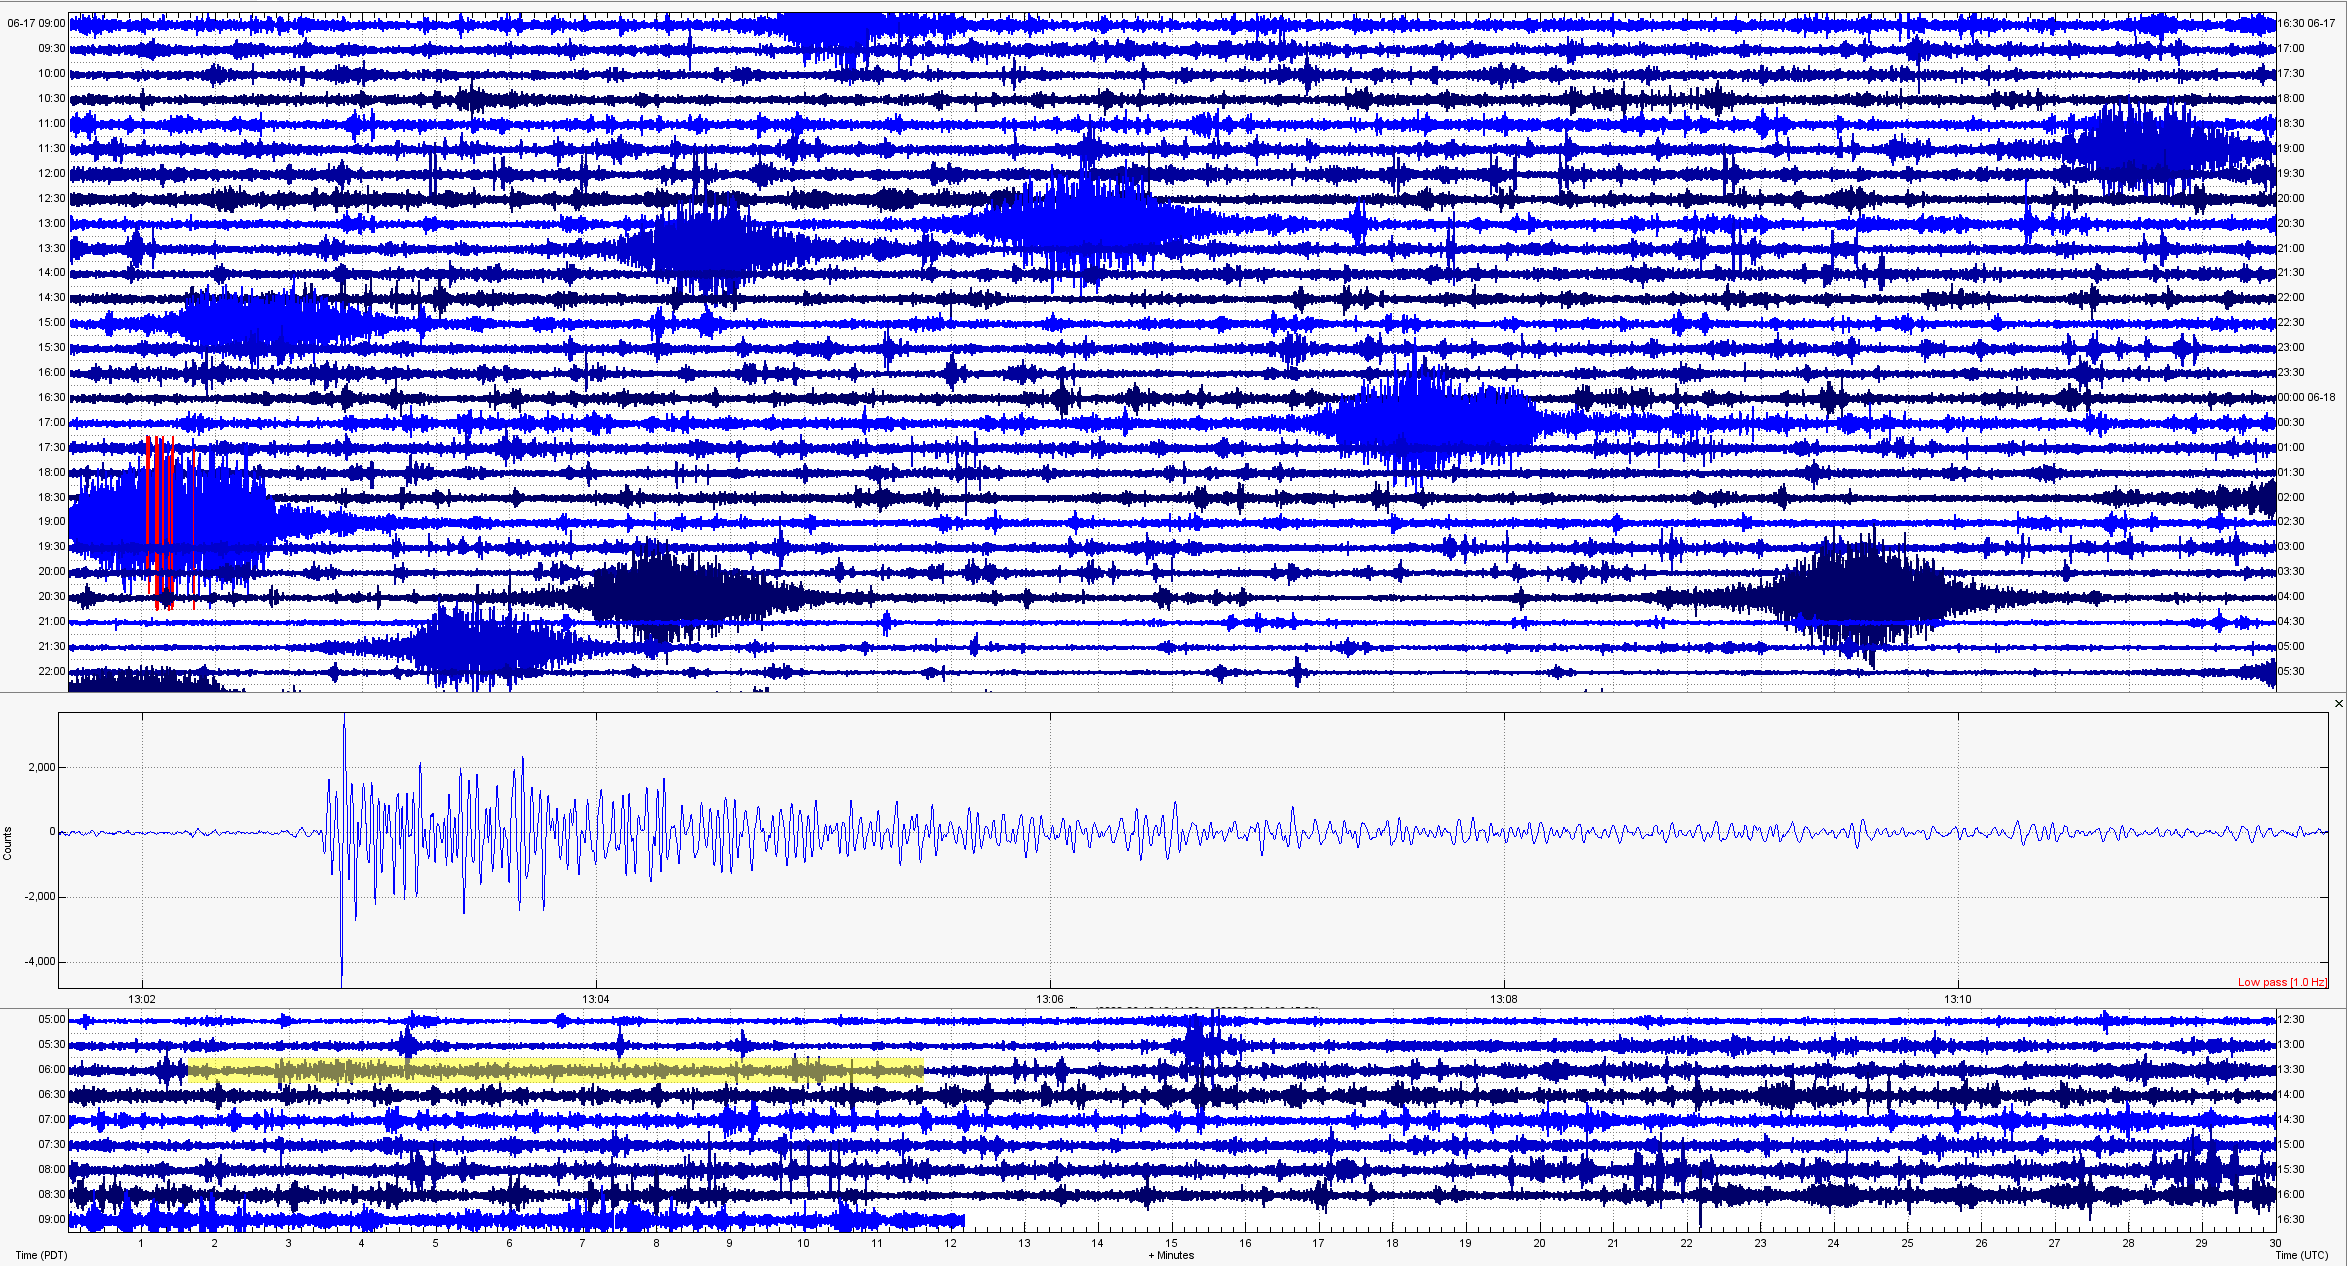

<br><br>

There are many more types of emergent signals.  What might be going on here,?  Again, the colour indicates the intensity of shaking at various frequencies, as documented by Hotovec et al (2013).  The x-axis measures time in minutes.


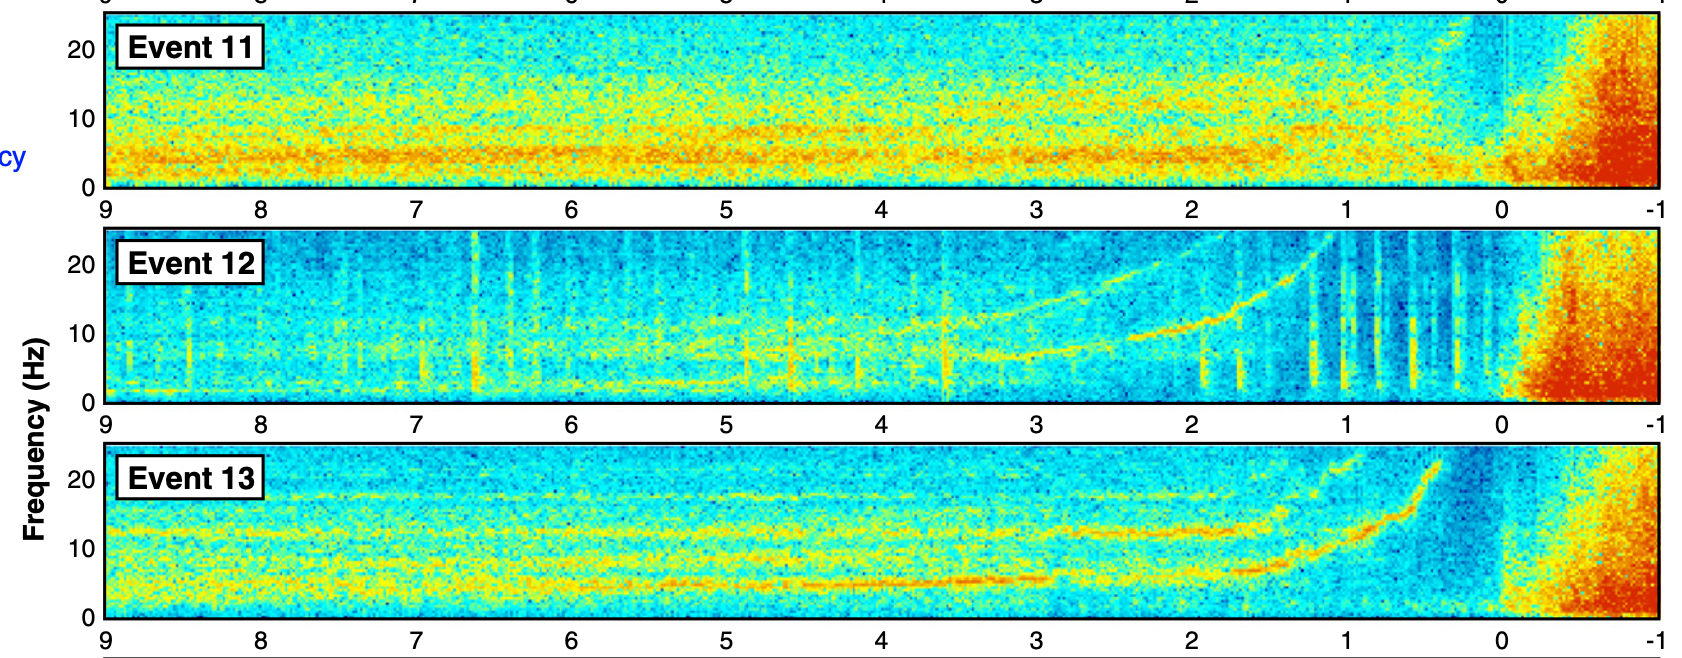